In [1]:
from mycnn import VGG16
from mycnn import utils
import tensorflow as tf
import numpy as np

In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_dataset.map(lambda x, y: (x/255., y))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


<MapDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [3]:
vgg16 = VGG16(classes_num=2)
vgg16.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 224, 224, 64)      256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 224, 224, 64)      256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 224, 224, 64)      0     

In [4]:
vgg16.setup_training(
    'log_vgg16',
    epochs=20,
    batch_size=20,  # batch size depend on ImageGenerator
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
vgg16.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, patience=10,
        min_lr=0.00001,
        verbose=1
    )
)

******************************
Loading last checkpoint...
Start traing from epoch 20
******************************
checkpoint_path : log_vgg16\weights
best_checkpoint : log_vgg16\weights.h5
epochs          : 20
initial_epoch   : 20
batch_size      : 20
optimizer       : <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x000002893AE37308>
loss            : categorical_crossentropy
metrics         : ['accuracy']


In [ ]:
vgg16.train_dataset(train_dataset, valid_dataset)

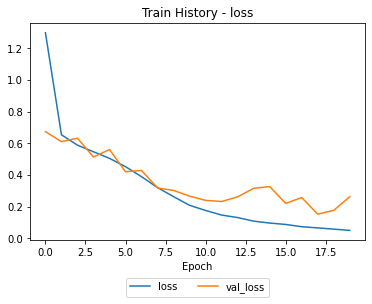

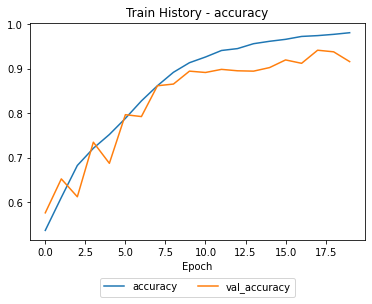

In [5]:
vgg16.show_history(["loss", "accuracy"])

In [6]:
vgg16.eval_dataset(valid_dataset)

250/250 [==============================] - 61s 229ms/step - loss: 0.2746 - accuracy: 0.9130


[0.26244598627090454, 0.9161999821662903]

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


100%|██████████| 5000/5000 [00:00<00:00, 498894.28it/s]


[[2328  165]
 [ 254 2253]] 

              precision    recall  f1-score   support

        Cats       0.90      0.93      0.92      2493
        Dogs       0.93      0.90      0.91      2507

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000
 



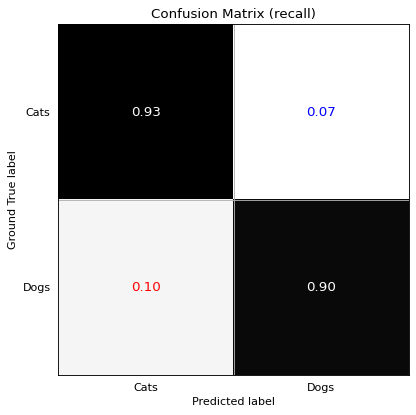

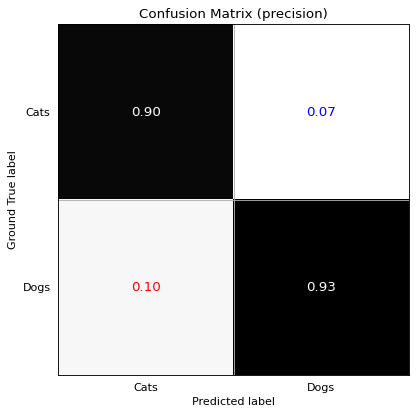

In [7]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = vgg16.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=vgg16.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, vgg16.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, vgg16.logdir, title='Confusion Matrix (precision)')